In [1]:
from __future__ import division, print_function

import warnings

import sns as sns

warnings.filterwarnings('ignore')

import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

In [50]:
data_07 = pd.read_parquet('data/yellow_tripdata_2020-07.parquet')
data_07.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-07-01 00:25:32,2020-07-01 00:33:39,1.0,1.50,1.0,N,238,75,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30,0.0,None
1,1,2020-07-01 00:03:19,2020-07-01 00:25:43,1.0,9.50,1.0,N,138,216,1,26.5,0.5,0.5,0.00,0.0,0.3,27.80,0.0,None
2,2,2020-07-01 00:15:11,2020-07-01 00:29:24,1.0,5.85,1.0,N,230,88,2,18.5,0.5,0.5,0.00,0.0,0.3,22.30,2.5,None
3,2,2020-07-01 00:30:49,2020-07-01 00:38:26,1.0,1.90,1.0,N,88,232,1,8.0,0.5,0.5,2.36,0.0,0.3,14.16,2.5,None
4,2,2020-07-01 00:31:26,2020-07-01 00:38:02,1.0,1.25,1.0,N,37,17,2,6.5,0.5,0.5,0.00,0.0,0.3,7.80,0.0,None


In [51]:
print('len before filtering: ', len(data_07))

data_07 = data_07.assign(tpep_dropoff_datetime=data_07.tpep_dropoff_datetime.dt.round('T'))
data_07 = data_07.assign(tpep_pickup_datetime=data_07.tpep_pickup_datetime.dt.round('T'))

data_07.airport_fee.fillna(0, inplace=True)
data_07.congestion_surcharge.fillna(0, inplace=True)
data_07.dropna(inplace=True)
data_07 = data_07[(data_07['passenger_count'] > 0) & (data_07['trip_distance'] > 0)]
data_07 = data_07[data_07['tpep_dropoff_datetime'] - data_07['tpep_pickup_datetime'] > timedelta(hours=0)]

print('len after filtering: ', len(data_07))

len before filtering:  800412
len after filtering:  692950


In [52]:
data_07 = data_07.assign(tpep_dropoff_datetime=data_07.tpep_dropoff_datetime.dt.round('H'))
data_07 = data_07.assign(tpep_pickup_datetime=data_07.tpep_pickup_datetime.dt.round('H'))

In [4]:
zone_df = pd.read_csv('taxi_zone_lookup.csv')

In [53]:
# Identify pickup and dropoff borough
data_07 = pd.DataFrame(pd.merge(data_07, zone_df[['LocationID', 'Borough', 'Zone']],
                                left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
data_07 = data_07.rename({'Borough':'PUborough', 'Zone': 'PUZone'}, axis=1)

data_07 = pd.DataFrame(pd.merge(data_07, zone_df[['LocationID', 'Borough', 'Zone']],
                                left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)

data_07 = data_07.rename({'Borough':'DOborough', 'Zone': 'DOZone'}, axis=1)

In [54]:
# Identify pick up and dropoff location thats from airport

data_07.loc[data_07['PULocationID'] == 132, 'PUborough'] = 'JFK'
data_07.loc[data_07['DOLocationID'] == 132, 'DOborough'] = 'JFK'
data_07.loc[data_07['PULocationID'] == 138, 'PUborough'] = 'LaGuardia'
data_07.loc[data_07['DOLocationID'] == 138, 'DOborough'] = 'LaGuardia'

In [55]:
data_07

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PUborough,PUZone,DOborough,DOZone
0,1,2020-07-01 00:00:00,2020-07-01 01:00:00,1.0,1.50,1.0,N,238,75,2,...,0.00,0.00,0.3,9.30,0.0,0,Manhattan,Upper West Side North,Manhattan,East Harlem South
1,2,2020-07-01 01:00:00,2020-07-01 01:00:00,1.0,1.67,1.0,N,238,75,1,...,2.79,0.00,0.3,12.09,0.0,0,Manhattan,Upper West Side North,Manhattan,East Harlem South
2,2,2020-07-01 04:00:00,2020-07-01 04:00:00,1.0,1.15,1.0,N,238,75,1,...,1.82,0.00,0.3,9.12,0.0,0,Manhattan,Upper West Side North,Manhattan,East Harlem South
3,2,2020-07-01 06:00:00,2020-07-01 06:00:00,1.0,2.16,1.0,N,238,75,1,...,2.76,0.00,0.3,16.56,2.5,0,Manhattan,Upper West Side North,Manhattan,East Harlem South
4,1,2020-07-01 07:00:00,2020-07-01 07:00:00,1.0,1.20,1.0,N,238,75,1,...,1.22,0.00,0.3,8.02,0.0,0,Manhattan,Upper West Side North,Manhattan,East Harlem South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692945,1,2020-07-22 00:00:00,2020-07-22 01:00:00,1.0,23.30,1.0,N,70,172,1,...,0.00,12.24,0.3,83.04,0.0,0,Queens,East Elmhurst,Staten Island,New Dorp/Midland Beach
692946,1,2020-07-18 12:00:00,2020-07-18 13:00:00,1.0,25.40,1.0,N,186,187,1,...,0.00,41.25,0.3,113.55,2.5,0,Manhattan,Penn Station/Madison Sq West,Staten Island,Port Richmond
692947,2,2020-07-22 22:00:00,2020-07-22 23:00:00,1.0,22.12,1.0,N,68,187,1,...,5.00,12.24,0.3,84.04,2.5,0,Manhattan,East Chelsea,Staten Island,Port Richmond
692948,1,2020-07-24 01:00:00,2020-07-24 01:00:00,1.0,17.40,1.0,N,87,187,1,...,0.00,12.24,0.3,65.04,2.5,0,Manhattan,Financial District North,Staten Island,Port Richmond


In [56]:
agr = data_07[['tpep_pickup_datetime', 'PULocationID', 'trip_distance']].groupby(by=['tpep_pickup_datetime', 'PULocationID'], as_index=False).count().rename({'trip_distance': 'trip_count'}, axis=1)

agr = pd.pivot_table(agr, values='trip_count', index=['tpep_pickup_datetime'],
                     columns=['PULocationID'], aggfunc=np.sum).fillna(0)

<AxesSubplot:>

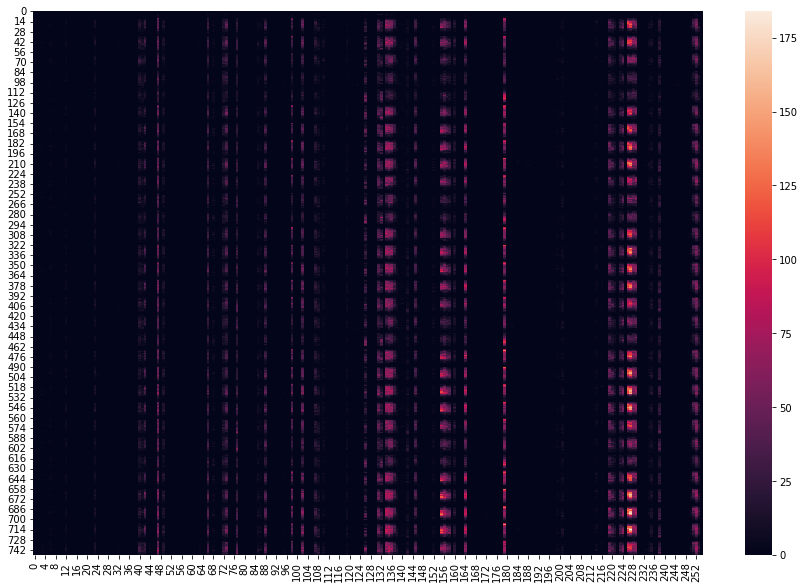

In [63]:
plt.figure(figsize = (15, 10))
sns.heatmap(agr.values)

<AxesSubplot:>

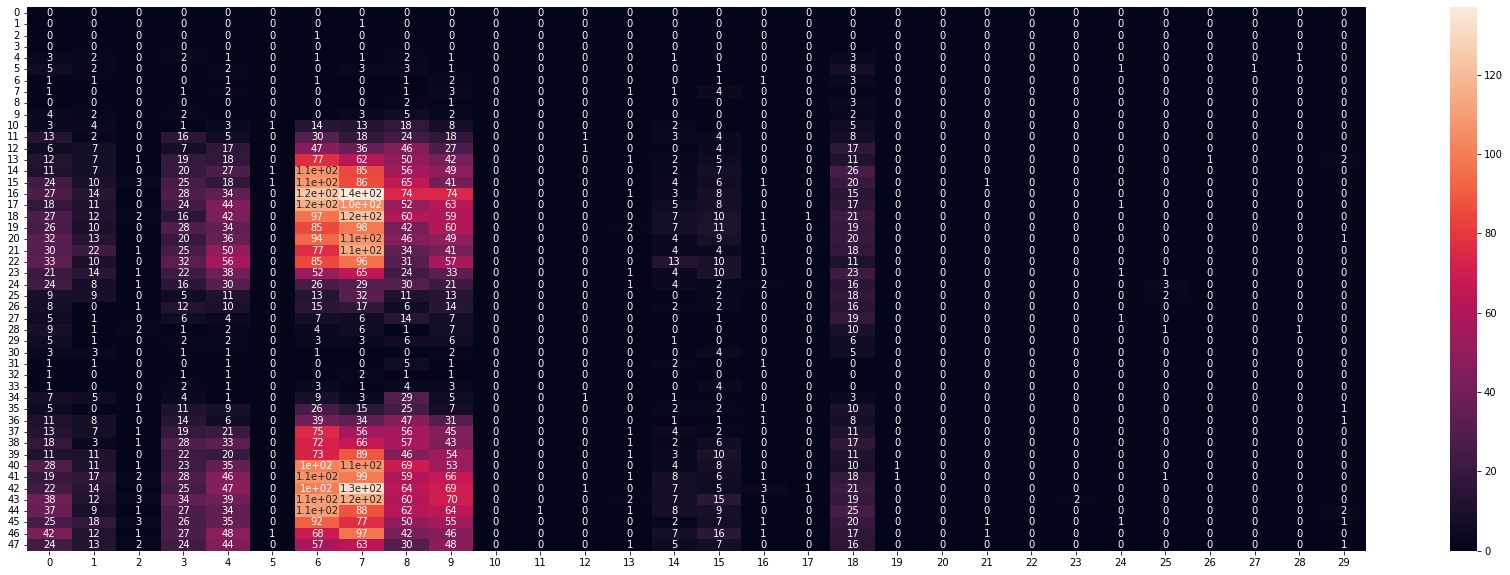

In [61]:
# ESB будут во второй части, тк формат данных изменился с 2021 года.

plt.figure(figsize = (30, 10))
sns.heatmap(agr.values[:48, 220:250], annot=True)

In [65]:
print('Количество ячеейк с нулевыми поездками - ', np.size(agr) - np.count_nonzero(agr))

Количество ячеейк с нулевыми поездками -  140116


In [2]:
from glob import glob
import os

PATH_TO_DATA = 'data/aggregated_data/'
def get_aggregated_data(filename, zone_df):
    data = pd.read_parquet(filename)
    data = data.assign(tpep_dropoff_datetime=data.tpep_dropoff_datetime.dt.round('T'))
    data = data.assign(tpep_pickup_datetime=data.tpep_pickup_datetime.dt.round('T'))

    data.airport_fee.fillna(0, inplace=True)
    data.dropna(inplace=True)
    data = data[(data['passenger_count'] > 0) & (data['trip_distance'] > 0)]
    data = data[data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime'] > timedelta(hours=0)]

    data = data.assign(tpep_dropoff_datetime=data.tpep_dropoff_datetime.dt.round('H'))
    data = data.assign(tpep_pickup_datetime=data.tpep_pickup_datetime.dt.round('H'))

    # Identify pickup and dropoff borough
    zone_df = pd.read_csv('taxi_zone_lookup.csv')
    data = pd.DataFrame(pd.merge(data, zone_df[['LocationID', 'Borough', 'Zone']],
                                    left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
    data = data.rename({'Borough':'PUborough', 'Zone': 'PUZone'}, axis=1)

    data = pd.DataFrame(pd.merge(data, zone_df[['LocationID', 'Borough', 'Zone']],
                                    left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)

    data = data.rename({'Borough':'DOborough', 'Zone': 'DOZone'}, axis=1)

    # Identify pick up and dropoff location thats from airport

    data.loc[data['PULocationID'] == 132, 'PUborough'] = 'JFK'
    data.loc[data['DOLocationID'] == 132, 'DOborough'] = 'JFK'
    data.loc[data['PULocationID'] == 138, 'PUborough'] = 'LaGuardia'
    data.loc[data['DOLocationID'] == 138, 'DOborough'] = 'LaGuardia'

    agr = data[['tpep_pickup_datetime', 'PULocationID', 'trip_distance']].groupby(by=['tpep_pickup_datetime', 'PULocationID'], as_index=False).count().rename({'trip_distance': 'trip_count'}, axis=1)

    agr = pd.pivot_table(agr, values='trip_count', index=['tpep_pickup_datetime'],
                         columns=['PULocationID'], aggfunc=np.sum).fillna(0)

    return agr

In [5]:
for filename in glob('data/*'):
    if filename != r'data\aggregated_data':
        aggregated_data = get_aggregated_data(filename, zone_df)
        with open(os.path.join(PATH_TO_DATA, 'agg_' + filename[5:filename.find('.')] + '.pkl'), 'wb') as file_pkl:
            pickle.dump(aggregated_data, file_pkl, protocol=2)